In [2]:
%matplotlib inline
import numpy as np
from astropy.io import fits as pf
import matplotlib
from matplotlib import pyplot as plt
import scipy.interpolate as sciinterp
import scipy

In [3]:
def openFile(filename):
    
    """Given the filename of a fits file extracts the data.
       Works on both flux and wavlength solution files."""
    
    file = pf.open(filename)
    
    return file[0].data

In [4]:
def rms2Spectra(spec1, spec2):
    
    """Determines the RMS value between two spectra 
       using N-1 normalization. """
    
    assert len(spec1) == len(spec2)
    diff = np.array([])
    for fluxval in range(len(spec1)):
        diff = np.append(diff, spec1[fluxval] - spec2[fluxval])
    diffsquares = diff**2
    sumsquares = np.sum(diffsquares)
    normed = sumsquares/(len(spec1) - 1)
    return normed**(0.5)

In [5]:
flux1 = openFile("rarp.210.fits")

In [6]:
flux2 = openFile("rbdl.232.fits")

In [7]:
wavelength = openFile("apf_wave_mod.fits")

In [8]:
#normalize 
def normalize(x, y):
    
    """Normalizes the y values and centers the x values
       around 0. """
    
    wavelength_range = max(x) - min(x)
    wave_center = x - min(x) - wavelength_range/2.
    norm_spectrum = y/max(y)
    return wave_center, norm_spectrum

In [9]:
def sectionAndAverage(wavelengths, flux, sections):
    
    """Split the wavelength and flux into bins of approximately 
       the same size according to sections value. Remove the values
       at or below the 5th percentile of brightness. Take the average
       of the remaining brightness values. Choose a wavelength 
       value that corresponds to the center of the bin."""
    
    #Find average flux of each bin after removing
    #Lowest flux values (bottom 5th percentile)
    flux_blocks = np.array_split(flux, sections)
    averages = np.array([])
    for section in flux_blocks:
        percentile5 = np.percentile(section, 5)
        morethan5th = section[section > percentile5]
        sectionavg = np.average(morethan5th)
        averages = np.append(averages, sectionavg)
    
    #Find wavelength value for bins
    wavesections = np.array_split(wavelengths, sections)
    points = np.array([])
    for section in wavesections:
        section_point = section[int(len(section)/2)]
        points = np.append(points, section_point)
        
    return points, averages

In [10]:
def removeBlazev1(wavelength, flux, sections, polydegree):
    
    """This method of blaze function removal first normalizes 
       the flux and centers the wavelength solution before fitting
       the coefficients for the polynomial model."""
    
    #Normalize the spectra, section, take relevant percentile values
    #and average flux in each bin.
    wave_center, norm_spectrum = normalize(wavelength, flux)
    points, averages = sectionAndAverage(wave_center, norm_spectrum, sections)
    
    #Fit the polynomial
    coef = np.polyfit(points, averages, polydegree)
    curve_fit = np.poly1d(coef)
    
    #Calculate RMS value between spectra and polynomial fit
    rmsNB = rms2Spectra(norm_spectrum, curve_fit(wave_center))
    
    #Plot the fit with the residuals
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
    fig.subplots_adjust(hspace=0)
    ax1 = axs[0]
    ax1.plot(wave_center, norm_spectrum)
    ax1.plot(wave_center, curve_fit(wave_center), "ro")
    ax1.title.set_text("Polynomial Blaze Function Fit (Norm Before Removal) RMS: " + str(np.round(rmsNB, 3)))
    ax1.set_ylabel("Normalized Flux")
    ax2 = axs[1]
    ax2.plot(wave_center, norm_spectrum - curve_fit(wave_center))
    ax2.set_ylabel("Residuals")
    plt.xlabel("Wavelength (A)")
    plt.show()
    
    #Return the flux after dividing out the flux determined
    #with the polynomial fit to be due to the blaze function
    return norm_spectrum/curve_fit(wave_center)

In [11]:
def removeBlazev2(wavelength, flux, sections, polydegree):
    
    """This version of blaze function removal does not normalize the
       flux or center the wavelengths before determining the polynomial
       coefficients, but normalizes with the division of the blaze function."""
    
    #Split spectra and wavelength solution into bins, average the 
    #appropriate flux values based on percentile, take mid-bin 
    #wavelength value to correspond to the bin's average
    points, averages = sectionAndAverage(wavelength, flux, sections)
    
    #Calculate the polynomial coefficients based on the above values
    coef = np.polyfit(points, averages, polydegree)
    curve_fit = np.poly1d(coef)
    
    #Calculate RMS between the spectra and the fit, large RMS
    #Value given non-normalized spectra
    rmsNB = rms2Spectra(flux, curve_fit(wavelength))
    
    #Plot the fit with the residuals
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
    fig.subplots_adjust(hspace=0)
    ax1 = axs[0]
    ax1.plot(wavelength, flux)
    ax1.plot(wavelength, curve_fit(wavelength), "ro")
    ax1.title.set_text("Polynomial Blaze Function Fit (Normalized with Polynomial) RMS: " + str(np.round(rmsNB, 3)))
    ax1.set_ylabel("Normalized Flux")
    ax2 = axs[1]
    ax2.plot(wavelength, flux - curve_fit(wavelength))
    ax2.set_ylabel("Residuals")
    plt.xlabel("Wavelength (A)")
    plt.show()
    
    #Return the flux with the blaze function divided out
    return flux/curve_fit(wavelength)

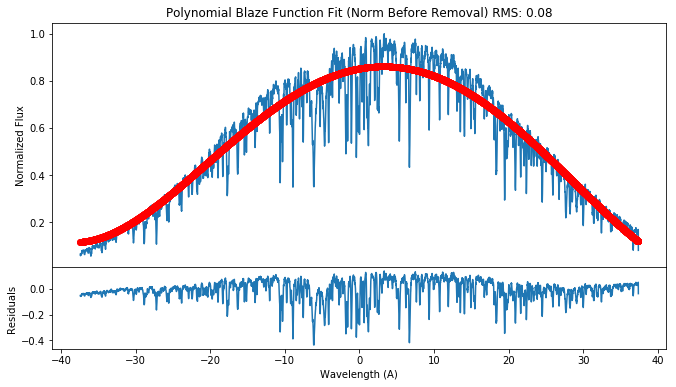

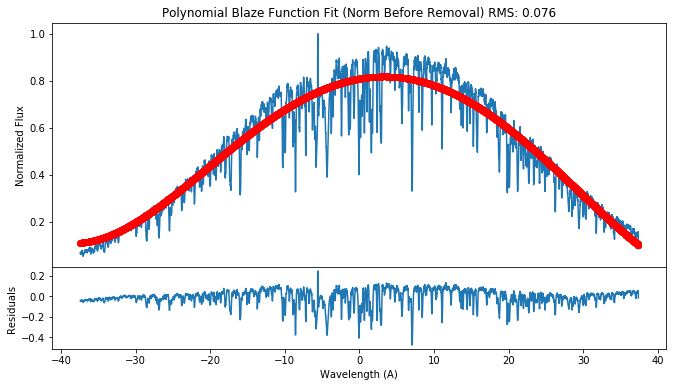

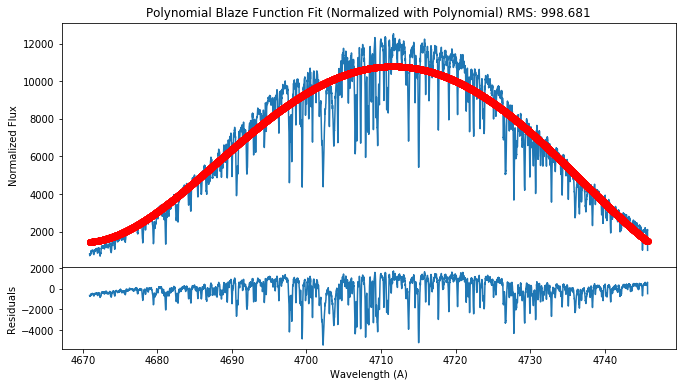

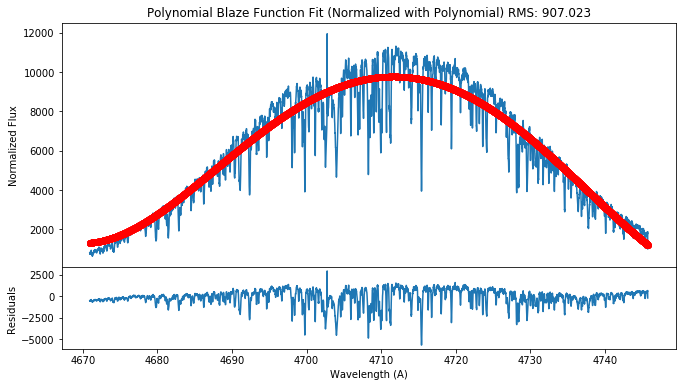

In [15]:
flux1NBv1 = removeBlazev1(wavelength[25], flux1[25], 6, 4)
flux2NBv1 = removeBlazev1(wavelength[25], flux2[25], 6, 4)
flux1NBv2 = removeBlazev2(wavelength[25], flux1[25], 6, 4)
flux2NBv2 = removeBlazev2(wavelength[25], flux2[25], 6, 4)

In [16]:
rmsNBv1 = rms2Spectra(flux1NBv1, flux2NBv1)
rmsNBv1

0.16874189129980174

In [17]:
rmsNBv2 = rms2Spectra(flux1NBv2, flux2NBv2)
rmsNBv2

0.16874193664074522

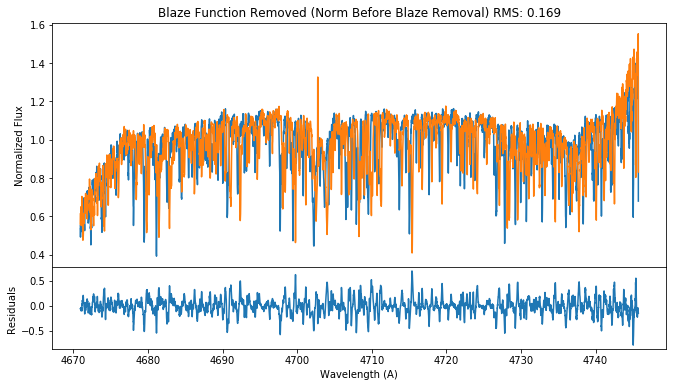

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(wavelength[25], flux1NBv1)
ax1.plot(wavelength[25], flux2NBv1)
ax1.title.set_text("Blaze Function Removed (Norm Before Blaze Removal) RMS: " + str(np.round(rmsNBv1, 3)))
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.plot(wavelength[25], flux1NBv1 - flux2NBv1)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

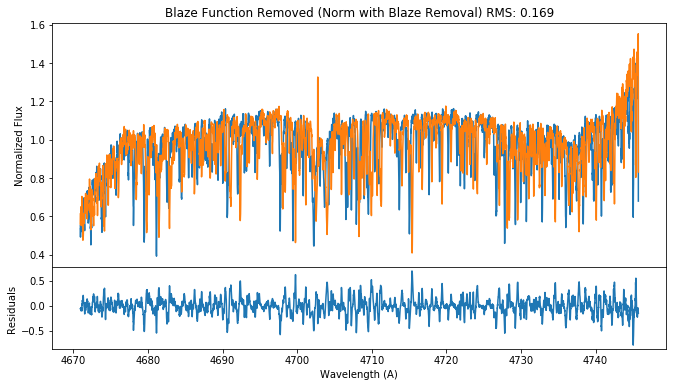

In [19]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(wavelength[25], flux1NBv2)
ax1.plot(wavelength[25], flux2NBv2)
ax1.title.set_text("Blaze Function Removed (Norm with Blaze Removal) RMS: " + str(np.round(rmsNBv2, 3)))
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.plot(wavelength[25], flux1NBv2 - flux2NBv2)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

## Create Blaze function removal using lamp

In [20]:
lamp = pf.open("rbel.139.fits")[0].data
wavelength = openFile("apf_wave_mod.fits")

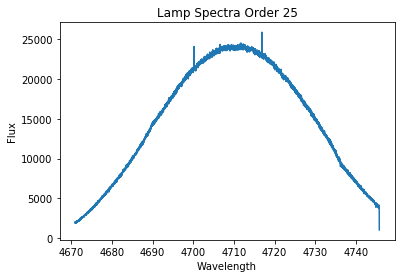

In [21]:
plt.plot(wavelength[25], lamp[25])
plt.title("Lamp Spectra Order 25")
plt.ylabel("Flux")
plt.xlabel("Wavelength")
plt.show()

In [23]:
def lampFit(wavelength, lamp, polydegree):
    
    """Takes in an order from the lamp spectra and returns
       A polynomial function with coefficients derived from
       the lamp's curve."""
    
    coef = np.polyfit(wavelength, lamp, polydegree)
    curve_fit = np.poly1d(coef)
    return curve_fit

In [25]:
lamp_fit25 = lampFit(wavelength[25], lamp[25], 5)
lampRMS = rms2Spectra(lamp[25], lamp_fit25(wavelength[25]))

/Users/MissaCarlson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys


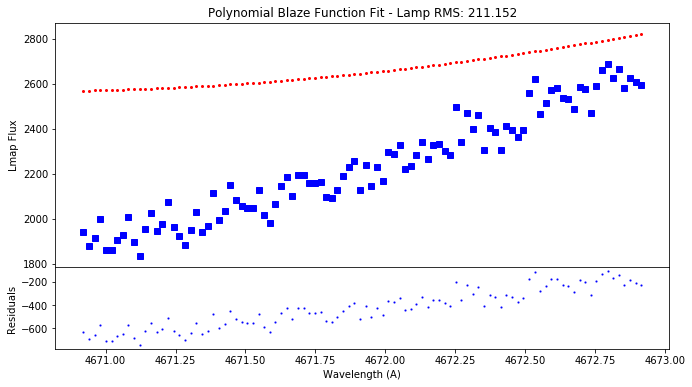

In [49]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(wavelength[25][0:100], lamp[25][0:100], 'bs')
ax1.plot(wavelength[25][0:100], lamp_fit25(wavelength[25][0:100]), "ro", markersize = 2)
ax1.title.set_text("Polynomial Blaze Function Fit - Lamp RMS: " + str(np.round(lampRMS, 3)))
ax1.set_ylabel("Lmap Flux")
ax2 = axs[1]
ax2.plot(wavelength[25][0:100], lamp[25][0:100] - lamp_fit25(wavelength[25][0:100]), 'bs', markersize = 1)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

In [27]:
def removeBlazeLamp(wavelength, lamp, flux, polydegree, order):
    lamp_fit = lampFit(wavelength[order], lamp[order], polydegree)
    return flux[order]/lamp_fit(wavelength[order])

In [28]:
flux1NBL = removeBlazeLamp(wavelength, lamp, flux1, 5, 25)
flux2NBL = removeBlazeLamp(wavelength, lamp, flux2, 5, 25)

/Users/MissaCarlson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/Users/MissaCarlson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys


In [29]:
rmsNBL = rms2Spectra(flux1NBL, flux2NBL)
rmsNBL

0.086379903392741875

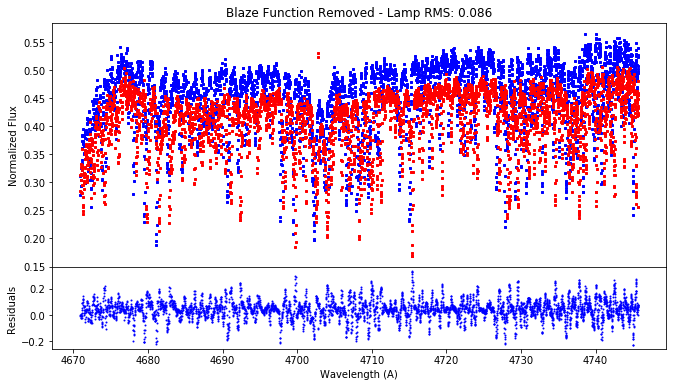

In [51]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(wavelength[25], flux1NBL, 'bs', markersize = 2)
ax1.plot(wavelength[25], flux2NBL, 'rs', markersize = 2)
ax1.title.set_text("Blaze Function Removed - Lamp RMS: " + str(np.round(rmsNBL, 3)))
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.plot(wavelength[25], flux1NBL - flux2NBL, 'bo', markersize = 1)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

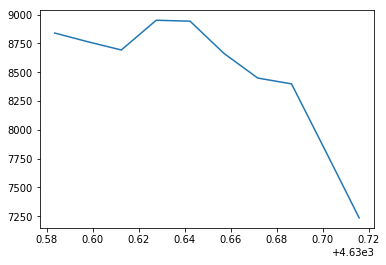

In [36]:
plt.plot(wavelength[23][2990:3000], flux1[23][2990:3000])

In [38]:
wavelength[45][3] - wavelength[45][2]

0.024916502508858684